# Question 4. MLMC for a random BVP (by Sarah-Jean Meyer)

Suggestion. Consider the 1D random PDE
$$\frac{d}{dx} \left ( \kappa(x) \frac{dp}{dx} \right ) = 0$$
on the unit interval $0 < x < 1$, subject to $p(0)=0$, $p(1)=1$, where
$u(x) = \log \kappa(x)$ is Gaussian with covariance $\mathbb{E}[u(x)u(y)] = \frac{1}{4} \exp(|x-y|)$:
The objective is to estimate the quantity
$$\mathbb{E} \left [ \int_0^1 \kappa\frac{dp}{dx}\; dx\right ] $$
You can choose how to construct samples of $u$ (Cholesky factorisation would
be simplest), and how to approximate the 1D equation (e.g. finite diference or
fnite element method).

The solution to the differential equation is:
$$p(x) = \frac{\int_0^x \kappa(x)^{-1} dx}{\int_0^1 \kappa(x)^{-1} dx}$$
and hence we have the following expression for the quantity of interest:
$$\mathcal I := \int_0^1 \kappa \frac{dp}{dx} \; dx= \left ( \int_0^1 \kappa(x)^{-1} \; dx\right )^{-1} $$
Therefore, given a sample of $\kappa$, we an approximate the QOI by estimating the intergral in terms of $\kappa$ only, or we can approximate a solution to $p$ and compute the integral directly.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.interpolate import interp1d
from IPython.display import display, Markdown
from pprint import pprint
from time import time

def pp2md(*args, **kwargs):
    '''pretty print to Markdown'''
    display(Markdown(*args, **kwargs))
    return

### The random field
Let us start with the basic functions needed to sample from $k$.

In [25]:
def u(num_samples, x_values, samples=[]):
    '''the function u in exercise 4, if no samples are provided, they are generated'''
    num_points=len(x_values)
    
    if not len(samples): samples = np.random.normal(size=(num_samples, num_points))
    # Build the covariance matrix for the samples
    cov = np.fromfunction(cov_function, (num_points, num_points), dtype=int)

    # Use cholesky to get the desired covariance
    samples = samples @ np.linalg.cholesky(cov)

    return samples


def cov_function(x,y):
    '''the covariance function in the exercise'''
    return 1/4*np.exp(-np.abs(x - y))


def k(num_samples, x_values, **kwargs):
    '''the function k in the exercise'''
    return np.exp(u(num_samples, x_values, **kwargs))


def derivative(y, x):
    '''computes the derivative of the array y with respect to x'''
    dy = np.zeros_like(y)
    dy[1:-1] = (y[2:] - y[:-2]) / (x[2:] - x[:-2])
    dy[0] = (y[1] - y[0]) / (x[1] - x[0])
    dy[-1] = (y[-1] - y[-2]) / (x[-1] - x[-2])
    return dy


def plot(fun, num_samples, x_values):
    # Generate 10 samples of the random function at 100 points between x=0 and x=1
    samples = fun(num_samples, x_values)
    # Plot the samples
    for sample in samples:
        plt.plot(x_values, sample)
    plt.show()

### Solving the BVP

To solve the PDE we use the solve_bvp provided by scipy. To this end we first transform the PDE to a first order system by introducing $q=p'$ to obtain 

In [26]:


def f(x, y, k_fun, k_der_fun):
    '''the first order rhs for the second order equation'''
    return np.vstack((y[1], - k_fun(x)/k_der_fun(x)*y[1]))


def bc(ya, yb):
    '''the boundary condition residuals to enforce p(0)=0, p(1)=1'''
    return np.array([ya[0], yb[0]-1])


def solve_pde(num_samples, x_values, grid=[], **kwargs):
    '''gets [num_samples] sample functions of the solution of the pde, returns k_samples and p_samples evaluated on the grid [grid]. If no grid is provided, x_values is used instead. If the noise is not provided, it is generated in this method as well.'''
    k_samples = k(num_samples, x_values, **kwargs)
    if not len(grid): grid=x_values
    dkdx_samples = np.array([derivative(k_values, x_values) for k_values in k_samples])

    # list to collect the function samples
    p_samples=[]

    for sample in range(num_samples):
        k_fun = const_interpolate(x_values, k_samples[sample])


        k_der_fun = const_interpolate(x_values, dkdx_samples[sample])

        y = solve_bvp(lambda x, y: f(x,y, k_fun, k_der_fun), bc, x_values, np.vstack((x_values, derivative(x_values,x_values))))
        p_samples += [y.sol(grid)[0]] # add the function for p to the list
    
    return k_samples, np.array(p_samples)


def const_interpolate(x_values, y_values):
    '''returns a piecewise constant interpolation of y over x assuming that x is evenly spaced'''
    grid_spacing = x_values[1]-x_values[0]
    def interpolation_function(x):
        x = np.asarray(x)
        x_index = (x / grid_spacing).astype(int)
        out_of_bounds = (x_index < 0) | (x_index >= len(y_values))
        x_index = np.clip(x_index, 0, len(y_values) - 1)
        return np.where(out_of_bounds, np.nan, y_values[x_index])
    return interpolation_function

def simple_plot_p(num_samples=10, x_values=np.linspace(0, 1), **kwargs):
    '''plots some sample solution p to the PDE in the exercise; additional kwargs are passed to plt.plot'''
    k_samples, p_samples=solve_pde(num_samples, x_values)
    for p_values in p_samples:
        plt.plot(x_values, p_values, **kwargs)
    plt.show()


### Naive Approximation

To get an idea for the value of the integral $\left(\int_0^1 \mathrm{d}x\, k(x)^{-1}\right)^{-1}$ and how well it can be approximated numerically, let us naively compute the integral.

In [27]:

def compute_expected_sol(x_values=np.linspace(0,1),
    num_samples=100):
    '''computes the estimates for the integral $\mathcal{I}$'''
    display(Markdown("Computing $\mathcal{I}$ using $\kappa$ only"))
    res=[]
    for i in range(5):
        k_samples=k(num_samples, x_values)
        I_values = np.array([np.mean(sample**(-1)) for sample in k_samples])**(-1)
        display(Markdown(rf"${i}$---$\hat E[\mathcal I]={np.mean(I_values)}$--$\hat V[\mathcal I]={np.var(I_values)}$"))
        res.append(np.mean(I_values))
    display(Markdown(rf"$V[\hat E[\mathcal I]]={np.var(res)}$"))
    return res
res = compute_expected_sol()


Computing $\mathcal{I}$ using $\kappa$ only

$0$---$\hat E[\mathcal I]=0.8891261939504023$--$\hat V[\mathcal I]=0.009271886748707056$

$1$---$\hat E[\mathcal I]=0.8893340553393588$--$\hat V[\mathcal I]=0.00952923789678585$

$2$---$\hat E[\mathcal I]=0.9036894874422196$--$\hat V[\mathcal I]=0.009372637993558043$

$3$---$\hat E[\mathcal I]=0.8735996549421913$--$\hat V[\mathcal I]=0.008305181211531452$

$4$---$\hat E[\mathcal I]=0.8869969139051094$--$\hat V[\mathcal I]=0.008511175602575768$

$V[\hat E[\mathcal I]]=9.121514265854408e-05$

We do the same thing for the integral involving the solution to the BVP.

In [28]:
def compute_expected_sol(x_values=np.linspace(0,1,100),
    num_samples=100, use_bvp=False):
    '''computes the integral $\mathcal{I}, use_bvp indicates whether the solution the the BVP should be used to compute the integral without eliminating $p$. $x_values$ is both the grid used to solve the BVP and to approximate the integral'''

    res=[]
    if not use_bvp:
        display(Markdown("Computing $\mathcal{I}$ using $\kappa$ only"))
        for i in range(5):
            k_samples=k(num_samples, x_values)
            I_values = np.array([np.mean(sample**(-1)) for sample in k_samples])**(-1)
            display(Markdown(rf"${i}$---$\hat E[I]={np.mean(I_values)}$--$\hat V[I]={np.var(I_values)}$"))
            res.append(np.mean(I_values))
    else:
        display(Markdown("Computing $\mathcal{I}$ using the solution $p$ to the BVP"))
        for i in range(5):
            k_samples, p_samples=solve_pde(num_samples, x_values)
            grad_p_samples = np.array([derivative(p_values, x_values) for p_values in p_samples])
            I_values = np.array([np.mean(k*grad_p) for (k,grad_p) in zip(k_samples, grad_p_samples)])
            display(Markdown(rf"${i}$---$\hat E[I]={np.mean(I_values)}$--$\hat V[I]={np.var(I_values)}$"))
            res.append(np.mean(I_values))
    display(Markdown(rf"$\mathbb V[\hat E[I]]={np.var(res)}$"))
    return res

In [6]:
import cProfile
import pstats
profile = cProfile.Profile()
profile.runcall(lambda: compute_expected_sol(use_bvp=True))
ps = pstats.Stats(profile).sort_stats("time")
ps.print_stats()

Computing $\mathcal{I}$ using the solution $p$ to the BVP

$0$---$\hat E[I]=1.1504197227155497$--$\hat V[I]=0.009007229122378477$

$1$---$\hat E[I]=1.1377084498124481$--$\hat V[I]=0.008290989983360413$

$2$---$\hat E[I]=1.12020447037643$--$\hat V[I]=0.005365887656021207$

$3$---$\hat E[I]=1.1394235202855947$--$\hat V[I]=0.007256745703889157$

$4$---$\hat E[I]=1.1343167126038936$--$\hat V[I]=0.00789945290636667$

$\mathbb V[\hat E[I]]=9.480810896728801e-05$

         11740535 function calls (11571404 primitive calls) in 19.190 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4463    2.677    0.001    2.677    0.001 {built-in method scipy.sparse.linalg._dsolve._superlu.gstrf}
784620/619952    0.751    0.000    3.828    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   108112    0.715    0.000    0.715    0.000 {method 'searchsorted' of 'numpy.ndarray' objects}
   216224    0.662    0.000    1.239    0.000 /home/sarah/.local/lib/python3.10/site-packages/numpy/core/_methods.py:92(_clip_dep_is_scalar_nan)
   108112    0.645    0.000    3.967    0.000 /usr/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:660(_call_nearest)
   279728    0.644    0.000    0.644    0.000 {method 'reduce' of 'numpy.ufunc' objects}
    13389    0.595    0.000    4.779    0.000 /usr/lib/python3.10/site-packages/scipy/integrate/_bvp.py:276(collocation_fun)
 

### With MLMC

Let $\{p_\ell\}_{\ell=1}^{L_{\text{max}}}$ be the approximate solution to the BVP using the grids $\{\pi_{\ell}\}_{\ell=1}^{L_{\text{max}}}$ where $\pi_{\ell}$ is a refinement of $\pi_{\ell-1}$.
Denoting the corresponding estimates for the integral $\mathcal I_{\ell}$, we have for any $L\leq L_{\text{max}}$
$$
    \mathbb E \mathcal I_L = \mathbb E \mathcal I_0 + \sum_{\ell = 1}^L \mathbb E [\mathcal I_\ell - \mathcal I_{\ell-1}]=: \sum_{\ell = 0}^L \mathbb E \delta\mathcal I_\ell.
$$ 

We will use dyadic refinements 
$$
    \pi_\ell := \{j2^{-{\ell}};\; j=0,1, ..., 2^\ell\}.
$$
We expect that for larger $\ell$, that $\mathbf V [\delta\mathcal I_\ell]\to 0$ so that fewer samples already yield a good estimator.
Therefor, at each level $\ell$, we reduce the number of samples we draw from $k$ and $p$

#### General MLMC functions

In [4]:
# MLMC function for level l

from numpy import random, zeros, array
from numpy import sum as npsum
from time import time

def mlmc_fn(l, N, problems, coupled_problem=False, sampler=None, N1 = 1):
    """
    Inputs:
        l: level
        N: number of paths
        problems: list of problems
            problems[l-1]: application-specific coarse problem (for l>0)
            problems[l]: application-specific fine problem 
            Problems must have an evaluate method such that
            problems[l].evaluate(sample) returns output P_l.
            Optionally, user-defined problems.cost
        coupled_problem: if True,
             problems[l].evaluate(sample) returns both P_l and P_{l-1}.
        sampler: sampling function, by default standard Normal.
            input: N, l
            output: (samplef, samplec). The fine and coarse samples.
         N1: number of paths to generate concurrently.

    Outputs:
        (sums, cost) where sums is an array of outputs:
        sums[0] = sum(Pf-Pc)
        sums[1] = sum((Pf-Pc)**2)
        sums[2] = sum((Pf-Pc)**3)
        sums[3] = sum((Pf-Pc)**4)
        sums[4] = sum(Pf)
        sums[5] = sum(Pf**2)
        cost = user-defined computational cost. By default, time
    """

    if sampler is None:
        def sampler(N, l):
            sample = random.randn(N)
            return (sample, sample)

    sums = zeros(6)
    cpu_cost = 0.0
    problemf = problems[l]
    if l>0:
        problemc = problems[l-1]

    for i in range(1, N+1, N1):
        N2 = min(N1, N - i + 1)

        samplef, samplec = sampler(N2,l)

        start = time()
        if coupled_problem:
            Pf, Pc = problems[l].evaluate(samplef) 
            print(l, Pf, Pc)
        else:
            Pf = problemf.evaluate(samplef)
            if l == 0:
                Pc = 0.
            else:
                Pc = problemc.evaluate(samplec)
            
        end = time()
        cpu_cost += end - start # cost defined as total computational time
        sums += array([npsum(Pf - Pc),
                       npsum((Pf - Pc)**2),
                       npsum((Pf - Pc)**3),
                       npsum((Pf - Pc)**4),
                       npsum(Pf),
                       npsum(Pf**2)])


    problem_cost_defined = hasattr(problemf, 'cost')
    problem_cost_defined = problem_cost_defined and problemf.cost is not None

    if problem_cost_defined:
        cost = N*problemf.cost
        if l>0:
            cost += N*problemc.cost # user-defined problem-specific cost
    else:
        cost = cpu_cost

    return (sums, cost)



import numpy
import numpy.linalg

class WeakConvergenceFailure(Exception):
    pass

def mlmc(Lmin, Lmax, N0, eps, mlmc_fn, alpha_0, beta_0, gamma_0, *args, **kwargs):
    """
    Multilevel Monte Carlo estimation.

    (P, Nl, Cl) = mlmc(...)

    Inputs:
      N0:   initial number of samples    >  0
      eps:  desired accuracy (rms error) >  0
      Lmin: minimum level of refinement  >= 2
      Lmax: maximum level of refinement  >= Lmin

      mlmc_fn: the user low-level routine for level l estimator. Its interface is

        (sums, cost) = mlmc_fn(l, N, *args, **kwargs)

        Inputs:  l: level
                 N: number of paths
                 *args, **kwargs: optional additional user variables

        Outputs: sums[0]: sum(Y)
                 sums[1]: sum(Y**2)
                    where Y are iid samples with expected value
                        E[P_0]            on level 0
                        E[P_l - P_{l-1}]  on level l > 0
                 cost: cost of N samples

      alpha ->  weak error is  O(2^{-alpha*l})
      beta  ->  variance is    O(2^{-beta*l})
      gamma ->  sample cost is O(2^{ gamma*l})

      If alpha, beta are not positive then they will be estimated.

      *args, **kwargs = optional additional user variables to be passed to mlmc_fn

    Outputs:
      P:  value
      Nl: number of samples at each level
      Cl: cost of samples at each level
    """

    # Check arguments

    if Lmin < 2:
        raise ValueError("Need Lmin >= 2")
    if Lmax < Lmin:
        raise ValueError("Need Lmax >= Lmin")
    if N0 <= 0 or eps <= 0:
        raise ValueError("Need N0 > 0, eps > 0")

    # Initialisation

    alpha = max(0, alpha_0)
    beta  = max(0, beta_0)
    gamma = max(0, gamma_0)

    theta = 0.25

    L = Lmin

    Nl   = numpy.zeros(L+1)
    suml = numpy.zeros((2, L+1))
    costl = numpy.zeros(L+1)
    dNl  = N0*numpy.ones(L+1)

    while sum(dNl) > 0:

        # update sample sums

        for l in range(0, L+1):
            if dNl[l] > 0:
                (sums, cost) = mlmc_fn(l, int(dNl[l]), *args, **kwargs)
                Nl[l]        = Nl[l] + dNl[l]
                suml[0, l]   = suml[0, l] + sums[0]
                suml[1, l]   = suml[1, l] + sums[1]
                costl[l]     = costl[l] + cost

        # compute absolute average, variance and cost

        ml = numpy.abs(       suml[0, :]/Nl)
        Vl = numpy.maximum(0, suml[1, :]/Nl - ml**2)
        Cl = costl/Nl

        # fix to cope with possible zero values for ml and Vl
        # (can happen in some applications when there are few samples)

        for l in range(3, L+2):
            ml[l-1] = max(ml[l-1], 0.5*ml[l-2]/2**alpha)
            Vl[l-1] = max(Vl[l-1], 0.5*Vl[l-2]/2**beta)

        # use linear regression to estimate alpha, beta, gamma if not given
        if alpha_0 <= 0:
            print('estimating alpha...', end="")
            A = numpy.ones((L, 2)); A[:, 0] = range(1, L+1)
            x = numpy.linalg.lstsq(A, numpy.log2(ml[1:]))[0]
            alpha = max(0.5, -x[0])
            print(f'alpha={alpha}')

        if beta_0 <= 0:
            print('estimating beta...', end="")
            A = numpy.ones((L, 2)); A[:, 0] = range(1, L+1)
            x = numpy.linalg.lstsq(A, numpy.log2(Vl[1:]))[0]
            beta = max(0.5, -x[0])
            print(f'beta={beta}')

        if gamma_0 <= 0:
            print('estimating gamma...', end="")
            A = numpy.ones((L, 2)); A[:, 0] = range(1, L+1)
            x = numpy.linalg.lstsq(A, numpy.log2(Cl[1:]))[0]
            gamma = max(0.5, x[0])
            print(f'gamma={gamma}')


        # set optimal number of additional samples

        Ns = numpy.ceil( numpy.sqrt(Vl/Cl) * sum(numpy.sqrt(Vl*Cl)) / ((1-theta)*eps**2) )
        dNl = numpy.maximum(0, Ns-Nl)
        # if (almost) converged, estimate remaining error and decide
        # whether a new level is required

        if sum(dNl > 0.01*Nl) == 0:
            # 23/3/18 this change copes with cases with erratic ml values
            rang = list(range(min(3, L)))
            rem = ( numpy.amax(ml[[L-x for x in rang]] / 2.0**(numpy.array(rang)*alpha))
                    / (2.0**alpha - 1.0) )
            # rem = ml[L] / (2.0**alpha - 1.0)
            print(f"remaining estimated error: {rem}")

            if rem > numpy.sqrt(theta)*eps:
                if L == Lmax:
                    print('failed to achieve weak convergence')
                    return sum(suml[0,:]/Nl), Nl, Cl
                    # raise WeakConvergenceFailure("Failed to achieve weak convergence")
                else:
                    L = L + 1
                    Vl = numpy.append(Vl, Vl[-1] / 2.0**beta)
                    Nl = numpy.append(Nl, 0.0)
                    suml = numpy.column_stack([suml, [0, 0]])
                    Cl = numpy.append(Cl, Cl[-1]*2**gamma)
                    costl = numpy.append(costl, 0.0)

                    Ns = numpy.ceil( numpy.sqrt(Vl/Cl) * sum(numpy.sqrt(Vl*Cl))
                            / ((1-theta)*eps**2) )
                    dNl = numpy.maximum(0, Ns-Nl)

    # finally, evaluate the multilevel estimator
    P = sum(suml[0,:]/Nl)

    return (P, Nl, Cl)


    import timeit
from datetime import datetime
import numpy
from math import sqrt
import sys


def mlmc_test(mlmc_fn, N, L, N0, Eps, Lmin, Lmax, logfile, *args, **kwargs):
    """
    Multilevel Monte Carlo test routine. Prints results to stdout and file.

    Inputs:
        mlmc_fn: the user low-level routine for level l estimator. Its interface is

          (sums, cost) = mlmc_fn(l, N, *args, **kwargs)

          Inputs:  l: level
                   N: number of samples
                   *args, **kwargs: optional additional user variables

          Outputs: sums[0]: sum(Y)
                   sums[1]: sum(Y**2)
                   sums[2]: sum(Y**3)
                   sums[3]: sum(Y**4)
                   sums[4]: sum(P_l)
                   sums[5]: sum(P_l**2)
                      where Y are iid samples with expected value
                          E[P_0]            on level 0
                          E[P_l - P_{l-1}]  on level l > 0
                   cost: user-defined computational cost of N samples

        N:    number of samples for convergence tests
        L:    number of levels for convergence tests

        N0:   initial number of samples for MLMC calculations
        Eps:  desired accuracy (rms error) array for MLMC calculations
        Lmin: minimum number of levels for MLMC calculations
        Lmax: maximum number of levels for MLMC calculations

        logfile: file handle for printing to file

        *args, **kwargs: optional additional user variables to be passed to mlmc_fn
    """

    now = datetime.now().strftime("%d-%B-%Y %H:%M:%S")
    # First, convergence tests
    write(logfile, "\n");
    write(logfile, "**********************************************************\n");
    write(logfile, "*** MLMC file version 0.9     produced by              ***\n");
    write(logfile, "*** Python mlmc_test on %s           ***\n" % now );
    write(logfile, "**********************************************************\n");
    write(logfile, "\n")
    write(logfile, "**********************************************************\n")
    write(logfile, "*** Convergence tests, kurtosis, telescoping sum check ***\n")
    write(logfile, "*** using N =%7d samples                           ***\n" % N)
    write(logfile, "**********************************************************\n")
    write(logfile, "\n l   ave(Pf-Pc)    ave(Pf)   var(Pf-Pc)  var(Pf)")
    write(logfile, "   kurtosis    check     cost\n-------------------------")
    write(logfile, "------------------------------------------------------\n")

    del1 = []
    del2 = []
    var1 = []
    var2 = []
    kur1 = []
    chk1 = []
    cost = []

    for l in range(0, L+1):

        (sums, cst) = mlmc_fn(l, N, *args, **kwargs)
        cst = cst/N
        sums = sums/N

        if l == 0:
            kurt = 0.0
        else:
            kurt = (     sums[3]
                     - 4*sums[2]*sums[0]
                     + 6*sums[1]*sums[0]**2
                     - 3*sums[0]*sums[0]**3 ) / (sums[1]-sums[0]**2)**2

        cost.append(cst)
        del1.append(sums[0])
        del2.append(sums[4])
        var1.append(sums[1]-sums[0]**2)
        var2.append(max(sums[5]-sums[4]**2, 1.0e-10)) # fix for cases with var = 0
        kur1.append(kurt)

        if l == 0:
            check = 0
        else:
            check =          abs(       del1[l]  +      del2[l-1]  -      del2[l])
            check = check / ( 3.0*(sqrt(var1[l]) + sqrt(var2[l-1]) + sqrt(var2[l]) )/sqrt(N))
        chk1.append(check)

        write(logfile, "%2d  %11.4e %11.4e  %.3e  %.3e  %.2e  %.2e  %.2e \n" % \
                      (l, del1[l], del2[l], var1[l], var2[l], kur1[l], chk1[l], cst))

    if kur1[-1] > 100.0:
        write(logfile, "\n WARNING: kurtosis on finest level = %f \n" % kur1[-1]);
        write(logfile, " indicates MLMC correction dominated by a few rare paths; \n");
        write(logfile, " for information on the connection to variance of sample variances,\n");
        write(logfile, " see http://mathworld.wolfram.com/SampleVarianceDistribution.html\n\n");

    if max(chk1) > 1.0:
        write(logfile, "\n WARNING: maximum consistency error = %f \n" % max(chk1))
        write(logfile, " indicates identity E[Pf-Pc] = E[Pf] - E[Pc] not satisfied; \n")
        write(logfile, " to be more certain, re-run mlmc_test with larger N \n\n")

    # Use linear regression to estimate alpha, beta and gamma
    L1 = 2;
    L2 = L+1;
    pa    = numpy.polyfit(range(L1+1, L2+1), numpy.log2(numpy.abs(del1[L1:L2])), 1);  alpha = -pa[0];
    pb    = numpy.polyfit(range(L1+1, L2+1), numpy.log2(numpy.abs(var1[L1:L2])), 1);  beta  = -pb[0];
    pg    = numpy.polyfit(range(L1+1, L2+1), numpy.log2(numpy.abs(cost[L1:L2])), 1);  gamma =  pg[0];

    write(logfile, "\n******************************************************\n");
    write(logfile, "*** Linear regression estimates of MLMC parameters ***\n");
    write(logfile, "******************************************************\n");
    write(logfile, "\n alpha = %f  (exponent for MLMC weak convergence)\n" % alpha);
    write(logfile, " beta  = %f  (exponent for MLMC variance) \n" % beta);
    write(logfile, " gamma = %f  (exponent for MLMC cost) \n" % gamma);

    # Second, MLMC complexity tests

    write(logfile, "\n");
    write(logfile, "***************************** \n");
    write(logfile, "*** MLMC complexity tests *** \n");
    write(logfile, "***************************** \n\n");
    write(logfile, "   eps       value     mlmc_cost   std_cost  savings     N_l \n");
    write(logfile, "------------------------------------------------------------ \n");

    alpha = max(alpha, 0.5)
    beta  = max(beta, 0.5)
    theta = 0.25

    for eps in Eps:
       (P, Nl, Cl) = mlmc(Lmin, Lmax, N0, eps, mlmc_fn, alpha, beta, gamma, *args, **kwargs)
       l = len(Nl) - 1
       mlmc_cost = numpy.dot(Nl,Cl)
       std_cost  = var2[-1]*Cl[min(len(Cl)-1,l)]/((1.0 -theta)*eps**2)

       write(logfile, "%.3e %11.4e  %.3e  %.3e  %7.2f " % (eps, P, mlmc_cost, std_cost, std_cost/mlmc_cost))
       write(logfile, " ".join(["%9d" % n for n in Nl]))
       write(logfile, "\n")

    write(logfile, "\n")

def write(logfile, msg):
    """
    Write to both sys.stdout and to a logfile.
    """
    logfile.write(msg)
    sys.stdout.write(msg)

import matplotlib
import matplotlib.pyplot as plt
import numpy
import os
from cycler import cycler

# Set matplotlib defaults to agree with MATLAB code
plt.rc("legend", framealpha=None)
plt.rc("legend", edgecolor='black')
plt.rc("font", family="serif")
# Following option for TeX text seems to not work with EPS figures?
#plt.rc("text", usetex=True)

# NOTE: set clip_on=False in plotting to get consistent style with MATLAB

def mlmc_plot(filename, nvert, error_bars=False):
    """
    Utility to generate MLMC diagnostic plots based on
    input text file generated by MLMC driver code mlmc_test.

    mlmc_plot(filename, nvert, error_bars=False)

    Inputs:
      filename: string, (base of) filename with output from mlmc_test routine
      nvert   : int, number of vertical plots <= 3
                    nvert == 1   generates fig1: (1),(2) fig2: (5),(6)
                    nvert == 2   generates fig1: (1),(2),(5),(6)
                    nvert == 3   generates fig1: (1)-(6)
      error_bars: bool, flag to add error bars in plots of level differences

    Outputs:
      Matplotlib figure(s) for
        Convergence tests
        (1) Var[P_l - P_{l-1}] per level
        (2) E[|P_l - P_{l-1}|] per level
        (3) cost per level
        (4) kurtosis per level
        Complexity tests
        (5) number of samples per level
        (6) normalised cost per accuracy target
    """

    #
    # read in data
    #

    # Default file extension is .txt if none supplied
    if not os.path.splitext(filename)[1]:
        file = open(filename + ".txt", "r")
    else:
        file = open(filename, "r")

    # Declare lists for data
    del1 = []
    del2 = []
    var1 = []
    var2 = []
    kur1 = []
    chk1 = []
    cost = []
    l    = []

    epss = []
    mlmc_cost = []
    std_cost = []
    Ns = []
    ls = []

    # Default values for number of samples and file_version
    N = 0
    file_version = 0.8

    complexity_flag = False # first read convergence tests rather than complexity tests
    for line in file:
        # Recognise file version line from the fact that it starts with '*** MLMC file version'
        if line[0:21] == '*** MLMC file version':
            file_version = float(line[23:30])
        # Recognise number of samples line from the fact that it starts with '*** using'
        if line[0:9] == '*** using':
            N = int(line[14:20])

        # Recognise whether we should switch to reading complexity tests
        if line[0:19] == '*** MLMC complexity':
            complexity_flag = True # now start to read complexity tests

        # Recognise MLMC complexity test lines from the fact that line[0] is an integer
        # Also need complexity_flag == True because line[0] is an integer also identifies
        # the convergence test lines
        if '0' <= line[0] <= '9' and complexity_flag:
            splitline = [float(x) for x in line.split()]
            epss.append(splitline[0])
            mlmc_cost.append(splitline[2])
            std_cost.append(splitline[3])
            Ns.append(splitline[5:])
            ls.append(list(range(0,len(splitline[5:]))))

        # Recognise convergence test lines from the fact that line[1] is an integer
        # and possibly also line[0] (or line[0] is whitespace)
        if (line[0] == ' ' or '0' <= line[0] <= '9') and '0' <= line[1] <= '9':
            splitline = [float(x) for x in line.split()]
            l.append(splitline[0])
            del1.append(splitline[1])
            del2.append(splitline[2])
            var1.append(splitline[3])
            var2.append(splitline[4])
            kur1.append(splitline[5])
            chk1.append(splitline[6])
            cost.append(splitline[7])
            continue

    if (file_version < 0.9):
        if (error_bars):
            raise Warning("Cannot plot error bars -- no value of N in file")
            error_bars = False

    # Compute variance of variance ( correct up to O(1/N) )
    if (error_bars):
        vvr1 = [ v**2 * (kur - 1.0) for (v, kur) in zip(var1,kur1)]

    #
    # plot figures
    #

    # Fudge to get comparable size to default MATLAB fig size
    width_MATLAB = 0.9*8; height_MATLAB = 0.9*6.5;
    plt.figure(figsize=([width_MATLAB, height_MATLAB*0.75*nvert]))

    plt.rc('axes', prop_cycle=(cycler('color', ['k']) *
                               cycler('linestyle', ['--', ':']) *
                               cycler('marker', ['*'])))

    # Var[P_l - P_{l-1}] per level
    plt.subplot(nvert, 2, 1)
    plt.plot(l,     numpy.log2(var2),     label=r'$P_\ell$', clip_on=False)
    plt.plot(l[1:], numpy.log2(var1[1:]), label=r'$P_\ell - P_{\ell-1}$', clip_on=False)
    plt.xlabel('level $\ell$')
    plt.ylabel(r'$\mathrm{log}_2(\mathrm{variance})$')
    plt.legend(loc='lower left', fontsize='medium')
    axis = plt.axis(); plt.axis([0, max(l), axis[2], axis[3]])

    if (error_bars):
        plt.plot(l[1:], numpy.log2(numpy.maximum(numpy.abs(numpy.array(var1[1:]) -
            3.0*numpy.sqrt(vvr1[1:])/numpy.sqrt(N)), 1e-10)), '-r.', clip_on=False)
        plt.plot(l[1:], numpy.log2(              numpy.abs(numpy.array(var1[1:]) +
            3.0*numpy.sqrt(vvr1[1:])/numpy.sqrt(N))        ), '-r.', clip_on=False)

    # E[|P_l - P_{l-1}|] per level
    plt.subplot(nvert, 2, 2)
    plt.plot(l,     numpy.log2(numpy.abs(del2)),     label=r'$P_\ell$', clip_on=False)
    plt.plot(l[1:], numpy.log2(numpy.abs(del1[1:])), label=r'$P_\ell - P_{\ell-1}$', clip_on=False)
    plt.xlabel('level $\ell$')
    plt.ylabel(r'$\mathrm{log}_2(|\mathrm{mean}|)$')
    plt.legend(loc='lower left', fontsize='medium')
    axis = plt.axis(); plt.axis([0, max(l), axis[2], axis[3]])

    if (error_bars):
        plt.plot(l[1:], numpy.log2(numpy.maximum(numpy.abs(numpy.array(del1[1:]) -
            3.0*numpy.sqrt(var1[1:])/numpy.sqrt(N)), 1e-10)), '-r.', clip_on=False)
        plt.plot(l[1:], numpy.log2(              numpy.abs(numpy.array(del1[1:]) +
            3.0*numpy.sqrt(var1[1:])/numpy.sqrt(N))        ), '-r.', clip_on=False)

    if nvert == 3:
        # consistency check
#        plt.subplot(nvert, 2, 3)
#        plt.plot(l[1:], chk1[1:], '*--')
#        plt.xlabel('level $\ell$')
#        plt.ylabel(r'consistency check')
#        axis = plt.axis(); plt.axis([0, max(l), axis[2], axis[3]])

        # cost per level
        plt.subplot(nvert, 2, 3)
        plt.plot(l, numpy.log2(cost), '*--', clip_on=False)
        plt.xlabel('level $\ell$')
        plt.ylabel(r'$\log_2$ cost per sample')
        axis = plt.axis(); plt.axis([0, max(l), axis[2], axis[3]])

        # kurtosis per level
        plt.subplot(nvert, 2, 4)
        plt.plot(l[1:], kur1[1:], '*--', clip_on=False)
        plt.xlabel('level $\ell$')
        plt.ylabel(r'kurtosis')
        axis = plt.axis(); plt.axis([0, max(l), axis[2], axis[3]])

    if nvert == 1:
        # Fix subplot spacing
        plt.subplots_adjust(wspace=0.3)
        plt.subplots_adjust(hspace=0.4)
        plt.figure(figsize=(width_MATLAB, height_MATLAB*0.75*nvert))

    marker_styles = ['o', 'x', 'd', '*', 's']
    plt.rc('axes', prop_cycle=(cycler('color', ['k']) *
                               cycler('linestyle', ['--']) *
                               cycler('marker', marker_styles)))

    # number of samples per level
    plt.subplot(nvert, 2, 2*nvert-1)
    for (eps, ll, n) in zip(epss, ls, Ns):
        plt.semilogy(ll, n, label=eps, markerfacecolor='none', clip_on=False)
    plt.xlabel('level $\ell$')
    plt.ylabel('$N_\ell$')
    plt.legend(loc='upper right', frameon=True, fontsize='medium')
    axis = plt.axis(); plt.axis([0, max([max(x) for x in ls]), axis[2], axis[3]])


    plt.rc('axes', prop_cycle=(cycler('color', ['k']) *
                               cycler('linestyle', ['--', ':']) *
                               cycler('marker', ['*'])))

    # normalised cost for given accuracy
    eps = numpy.array(epss)
    std_cost = numpy.array(std_cost)
    mlmc_cost = numpy.array(mlmc_cost)
    I = numpy.argsort(eps)
    plt.subplot(nvert, 2, 2*nvert)
    plt.loglog(eps[I], eps[I]**2 * std_cost[I],  '*-',  label='Std MC', clip_on=False)
    plt.loglog(eps[I], eps[I]**2 * mlmc_cost[I], '*--', label='MLMC',   clip_on=False)
    plt.xlabel(r'accuracy $\varepsilon$')
    plt.ylabel(r'$\varepsilon^2$ cost')
    plt.legend(fontsize='medium')
    axis = plt.axis(); plt.axis([min(eps), max(eps), axis[2], axis[3]])

    # Fix subplot spacing
    plt.subplots_adjust(wspace=0.3)
    plt.subplots_adjust(hspace=0.4)
    plt.show()
    return



### For the integral directly

We first perfom the tests for the integral without computing the solution to the PDE. 
Using the MLMC functions defined above, we can define the problems at each level and pass the problem to mlmc using mlmc_fn as defined above.

In [13]:

Lmin = 2    # mimimum depth of the mlmc
Lmax = 5    # maximum depth of the mlmc
offset = 5  # 2^offset+1 points will be used at level 0 in the grid, with dyadic refinements afterwards
N0 = 1e3    # initial number of samples on the coarsest level
eps = 1e-3  # desired precision of the estimate


class Problem_k_only(object):
    '''The class to define the subproblems at level l computing the pde solution'''
    def __init__(self, l):
        self.grid = np.linspace(0,1, 2**(l+offset)+1) # the grid to use at level l
        self.level = l

    def evaluate(self, sample):
        '''Returns del I_\ell; c.f. mlmc_fun'''
        k_samples = k(len(sample), self.grid, samples=sample)
        I_sample = [np.mean(k**(-1)) for k in k_samples]
        return np.array(I_sample)**(-1)


problem_list_k = [Problem_k_only(l) for l in range(Lmax+1)]

def sampler(N, L):
    '''the sampler to use for the problem; note that the samples for the coarse problems are a subset of the fine problem'''
    fine = np.random.normal(size=(N, 2**(L+offset)+1))
    coarse = fine[:,::2]
    return (fine, coarse)

def mlmc_fun_k_only(l, N, problems):
    '''use prebuild mlmc function to get mlmc_fun for the problems above'''
    return mlmc_fn(l, N, problem_list_k, sampler=sampler)

def test():
    return mlmc(Lmin, Lmax, N0=N0, eps=eps, mlmc_fn=mlmc_fun_k_only, alpha_0=-1, beta_0=-1, gamma_0=-1, problems=problem_list_k)

In [9]:
# import cProfile
# import pstats
# profile = cProfile.Profile()
# profile.runcall(test)
# ps = pstats.Stats(profile)
# ps.print_stats()
print(test())

estimating alpha...alpha=0.8519213816384994
estimating beta...beta=0.9976300318558042
estimating gamma...gamma=1.4506233194367784


/tmp/ipykernel_143998/3676468243.py:187: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = numpy.linalg.lstsq(A, numpy.log2(ml[1:]))[0]
/tmp/ipykernel_143998/3676468243.py:194: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = numpy.linalg.lstsq(A, numpy.log2(Vl[1:]))[0]
/tmp/ipykernel_143998/3676468243.py:201: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to

estimating alpha...alpha=0.846534752470891
estimating beta...beta=1.0002073942594807
estimating gamma...gamma=1.591353726082868
estimating alpha...alpha=0.8338672201142923
estimating beta...beta=0.9999775857561609
estimating gamma...gamma=1.54261004829021
remaining estimated error: 0.005383991923041549
estimating alpha...alpha=1.210139131754324
estimating beta...beta=0.990531950371464
estimating gamma...gamma=1.5443345901100103
estimating alpha...alpha=1.2284985668684945
estimating beta...beta=0.990072846481076
estimating gamma...gamma=1.5431430968102624
remaining estimated error: 0.001171919832680365
estimating alpha...alpha=0.9012688362653962
estimating beta...beta=0.9842895343623077
estimating gamma...gamma=1.9549932520157705
estimating alpha...alpha=0.9265254572790279
estimating beta...beta=0.9849836297717862
estimating gamma...gamma=1.9599769549334514
estimating alpha...alpha=0.9329361274226794
estimating beta...beta=0.9851669736212697
estimating gamma...gamma=1.9603277774938177
r

In [16]:
logfile = open("log_k.txt", "a")
N=int(1e3)

mlmc_test(mlmc_fun_k_only, N, Lmax, N0, np.array([1, 5, 10])*eps, Lmin, Lmax, logfile, problem_list_k)
logfile.close()


**********************************************************
*** MLMC file version 0.9     produced by              ***
*** Python mlmc_test on 04-January-2023 10:01:24           ***
**********************************************************

**********************************************************
*** Convergence tests, kurtosis, telescoping sum check ***
*** using N =   1000 samples                           ***
**********************************************************

 l   ave(Pf-Pc)    ave(Pf)   var(Pf-Pc)  var(Pf)   kurtosis    check     cost
-------------------------------------------------------------------------------
 0   9.0242e-01  9.0242e-01  1.446e-02  1.446e-02  0.00e+00  0.00e+00  1.15e-04 
 1  -6.9994e-03  8.8929e-01  6.562e-03  7.309e-03  3.20e+00  2.26e-01  7.19e-04 
 2  -2.6513e-03  8.8703e-01  3.478e-03  3.522e-03  3.16e+00  2.03e-02  7.89e-04 
 3  -4.9400e-03  8.8441e-01  1.754e-03  1.926e-03  2.97e+00  1.69e-01  1.96e-03 
 4  -5.6277e-04  8.8332e-01  9.197e-04 

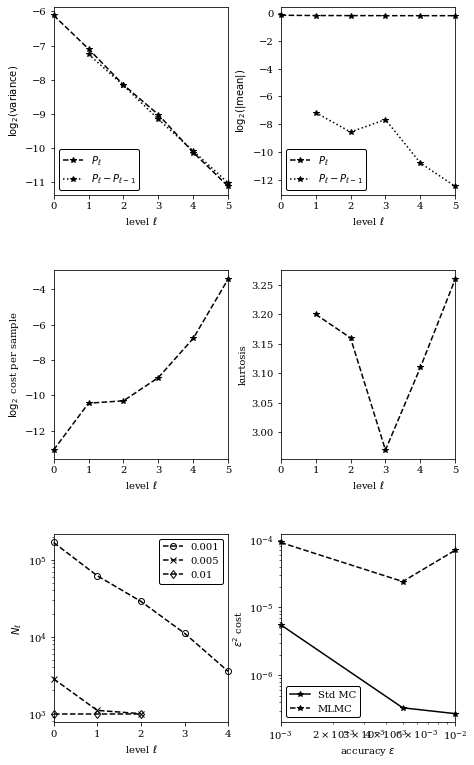

In [6]:
mlmc_plot('log_k', 3)

In [ ]:
class Problem_with_bvp(object):
    '''The class to define the subproblems at level l computing the pde solution'''
    def __init__(self, l):
        self.grid = np.linspace(0,1, 2**(l+offset)+1) # the grid to use at level l

    def evaluate(self, sample):
        '''Returns del I_\ell'''
        k_samples, p_samples = solve_pde(len(sample), self.grid, samples=sample)
        grad_p_samples = np.array([derivative(p_values, self.grid) for p_values in p_samples])
        I_sample = [np.mean(k*grad_p) for (k, grad_p) in zip(k_samples, p_samples)]
        return np.array(I_sample)

problem_list=[Problem_with_bvp(l) for l in range(Lmax+1)]

def mlmc_fun_wrapper(l, N, problems):
    return mlmc_fn(l, N, problem_list, sampler=sampler)

mlmc(Lmin, Lmax, N0=N0, eps=eps, mlmc_fn=mlmc_fun_wrapper, alpha_0=-1, beta_0=-1, gamma_0=-1, problems=problem_list)

In [ ]:
logfile = open("log_p.txt", "a")
N=int(5e2)

mlmc_test(mlmc_fun_wrapper, N, 2, N0, np.array([1, 5, 10])*eps, Lmin, Lmax-2, logfile, problem_list)
logfile.close()